<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

%%html
<style>
div {
    width: 80ch !important; /* or whatever width in whatever CSS units you want */
}
</style>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Load libraires. Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 40.91 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader,  class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ef0e626db40>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device
# model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model_0 = torchvision.models.efficientnet_b0(weights=weights).to(device)
#model_0 # uncomment to output (it's very long)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 67.6MB/s]


In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [9]:
summary(model_0, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 3]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         (864)
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         (64)
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         (1,448)
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           (6,004)
│    │    └─MBConv: 3-6                      

### Train model

In [10]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [11]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 15.326 seconds


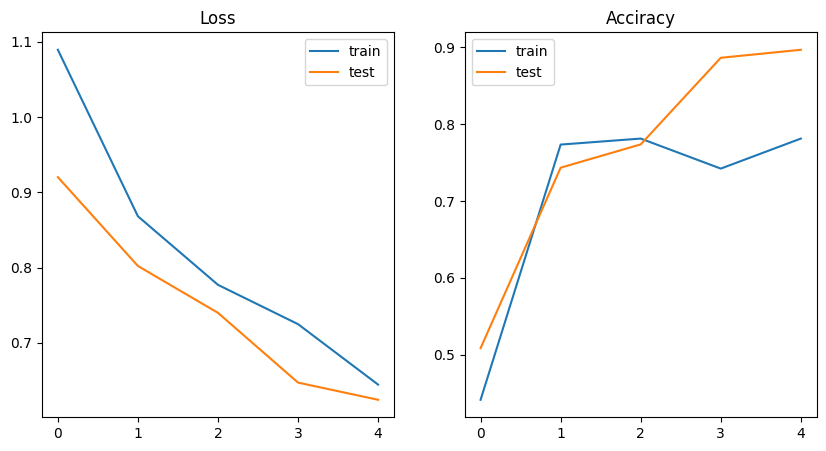

In [14]:
import matplotlib.pyplot as plt


def plot_results(results, title=None):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(results['train_loss'], label='train')
    plt.plot(results['test_loss'],  label='test')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(results['train_acc'], label='train')
    plt.plot(results['test_acc'], label='test')
    plt.title('Acciracy')
    plt.legend()


plot_results(results=model_0_results)

### Make predictions on the entire test dataset with the model

In [15]:
# TODO
def get_test_predictions(model, device):
    model.to(device)
    model.eval()

    y_pred = []
    y_prob = []

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_logit = model(X)

            y_prob_batch = torch.softmax(pred_logit, dim=1)
            y_pred_batch = y_prob_batch.argmax(dim=1)

            y_pred.append(y_pred_batch.cpu())
            y_prob.append(y_prob_batch.cpu())

    return torch.cat(y_pred), torch.cat(y_prob)

test_pred, test_prob = get_test_predictions(model=model_0, device=device)

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [16]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.1 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [17]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


In [18]:
type(test_dataloader.dataset.targets)

list

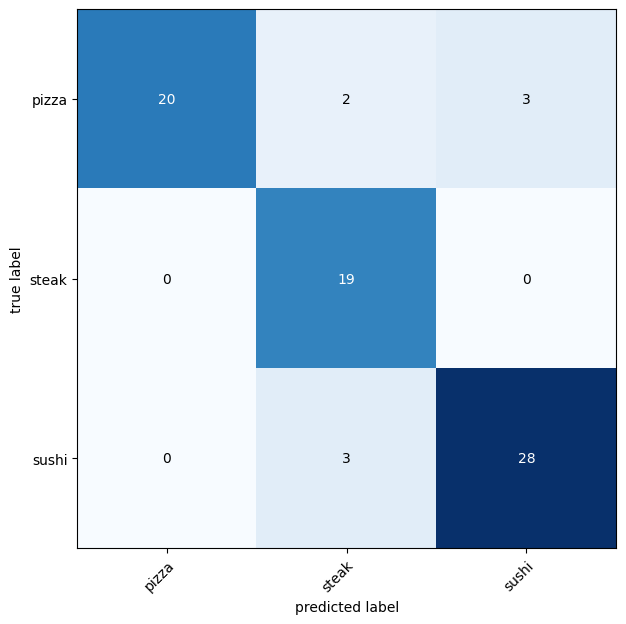

In [19]:
# DONE

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
test_target = torch.Tensor(test_dataloader.dataset.targets)
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=test_pred,
                         target=test_target)


# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy
    class_names=class_names,  # turn the row and column labels into class names
    figsize=(10, 7)
)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [20]:
 # DONE

import pandas as pd
samples_data = test_dataloader.dataset.samples
samples = [item[0] for item in samples_data]
test_probs = [float(i[i.argmax()]) for i in test_prob]

df_pred = pd.DataFrame({'sample': samples , 'predictions': test_pred, 'targets': test_target, 'probability': test_probs})
df_pred = df_pred.astype({'targets': 'int16'})
df_pred['correct'] = df_pred['predictions'] == df_pred['targets']
df_pred = df_pred.sort_values(['correct', 'probability'], ascending=[True, True])


df_top5 = df_pred[:5]
p = df_top5['sample'].iloc[0]
df_top5

# In the solution creates list where save dict for each item.

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
# def pred_and_store(test_paths, model, transform, class_names, device):
#   test_pred_list = []
#   for path in tqdm(test_paths):
#     # Create empty dict to store info for each sample
#     pred_dict = {}

#     # Get sample path
#     pred_dict["image_path"] = path

#     # Get class name
#     class_name = path.parent.stem
#     pred_dict["class_name"] = class_name

#     # Get prediction and prediction probability
#     from PIL import Image
#     img = Image.open(path) # open image
#     transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
#     model.eval()
#     with torch.inference_mode():
#       pred_logit = model(transformed_image.to(device))
#       pred_prob = torch.softmax(pred_logit, dim=1)
#       pred_label = torch.argmax(pred_prob, dim=1)
#       pred_class = class_names[pred_label.cpu()]

#       # Make sure things in the dictionary are back on the CPU
#       pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
#       pred_dict["pred_class"] = pred_class

#     # Does the pred match the true label?
#     pred_dict["correct"] = class_name == pred_class

#     # print(pred_dict)
#     # Add the dictionary to the list of preds
#     test_pred_list.append(pred_dict)

#   return test_pred_list

,sample,predictions,targets,probability,correct
10,data/pizza_steak_sushi/test/pizza/2218680.jpg,1,0,0.384089,False
55,data/pizza_steak_sushi/test/sushi/2276986.jpg,1,2,0.403894,False
13,data/pizza_steak_sushi/test/pizza/2871261.jpg,1,0,0.425909,False
15,data/pizza_steak_sushi/test/pizza/309892.jpg,2,0,0.426874,False
12,data/pizza_steak_sushi/test/pizza/2508636.jpg,2,0,0.435139,False


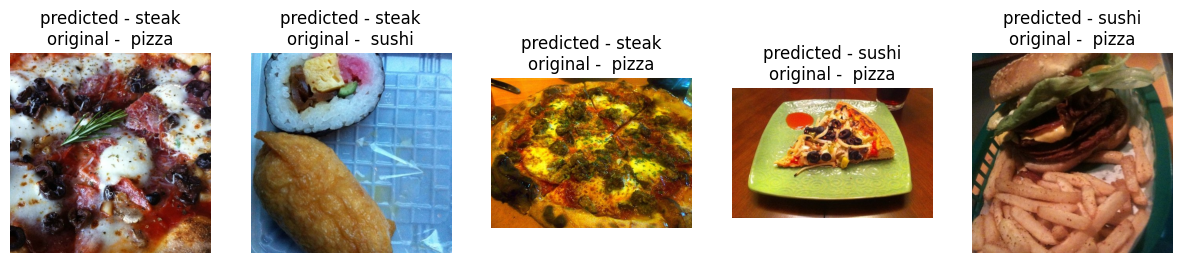

In [21]:
from PIL import Image

plt.figure(figsize=(15, 10))
# plt.suptitle('Most wrong')

for i, idx in enumerate(df_top5.index):
    path = df_top5['sample'].loc[idx]
    img = Image.open(path)
    img_ar = np.asanyarray(img)
    plt.subplot(1, 5, i+1)
    plt.axis(False)
    cnmuber = test_dataloader.dataset[idx][1]
    cnmuber_pred = df_top5['predictions'].loc[idx]
    plt.imshow(img)
    plt.title('predicted - ' + class_names[cnmuber_pred] +  '\n' + 'original -  ' + class_names[cnmuber])


## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [23]:
# DONE: Get an image of pizza/steak/sushi


def pred_and_plot_img(model, img_path):

    model.eval()

    model.to(device)

    with torch.inference_mode():
        img = Image.open(img_path)

        img_tr = simple_transform(img).unsqueeze(dim=0)
        logit_pred = model(img_tr.to(device))
        prob_pred = logit_pred.softmax(dim=1)
        target_pred = prob_pred.argmax(dim=1)

        plt.figure()
        plt.imshow(img)
        plt.title(
            f'class: {class_names[target_pred]}, prob: {prob_pred.max():.3f}')
        plt.axis(False)


data_path = Path('data\images')
img_path_list = []
img_path_list.append(data_path / 'pizza.jpg')
img_path_list.append(data_path / 'stake.jpg')
img_path_list.append(data_path / 'sushi.jpg')

pred_and_plot_img(model_0, img_path_list[3])

FileNotFoundError: [Errno 2] No such file or directory: '/content/data\\images/pizza_2.jpg'

In [ ]:
# DONE: Get an image of not pizza/steak/sushi
img_path = data_path / 'pelmeni.jpg'

pred_and_plot_img(model_0, img_path)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [ ]:
# TODO: Recreate a new model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)


# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,  # same number of output units as our number of classes
                    bias=True)).to(device)


summary(model_1,
        # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

In [ ]:
# TODO: Train the model for 10 epochs


# Set the random seeds
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)


start_time = timer()
# Setup training and save the results
model_1_results = engine.train(model=model_1,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=10,
                               device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
from my_sol_exercises.my_going_modular.plot import plot_results

plot_results(results=model_1_results)

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [ ]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

### Create DataLoaders

In [ ]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [ ]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

### Get a pretrained model

In [ ]:
# TODO

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b0(weights=weights).to(device)

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)




# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)



summary(model_2,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Try to test changing learning rate

### Train a model with 20% of the data

In [ ]:
# TODO

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
from my_sol_exercises.my_going_modular.plot import plot_results

plot_results(results=model_2_results)

Try to test changing learning rate

In [ ]:
# TODO

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_21 = torchvision.models.efficientnet_b0(weights=weights).to(device)

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_21.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)



summary(model_21,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
# TODO

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_21.parameters(), lr=0.0001)

# Setup training and save the results
model_2_results = engine.train(model=model_21,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
from my_sol_exercises.my_going_modular.plot import plot_results

plot_results(results=model_2_results)

## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [ ]:
# PREPARE DATA

transforms_b2 = torchvision.models.EfficientNet_B2_Weights.IMAGENET1K_V1.transforms()

# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_b2, test_dataloader_b2, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                     test_dir=test_dir_20_percent,
                                                                                     transform=transforms_b2,  # resize, convert images to between 0 & 1 and normalize them
                                                                                     batch_size=32)  # set mini-batch size to 32
train_dataloader_b2, test_dataloader_b2, class_names

In [ ]:
transforms_b2

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
# TODO

weights = torchvision.models.EfficientNet_B2_Weights.IMAGENET1K_V1
model_3 = torchvision.models.efficientnet_b2(weights=weights).to(device)

model_3 = model_3.to(device=device)

In [ ]:


# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape,  # same number of output units as our number of classes
                    bias=True)).to(device)

# print(model_3)

In [ ]:
summary(model_3,
        # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        input_size=(1, 3, 288, 288),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        device='cpu'
        )

In [ ]:
# TODO

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

# Setup training and save the results
model_3_results = engine.train(model=model_3,
                       train_dataloader=train_dataloader_b2,
                       test_dataloader=test_dataloader_b2,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
from my_sol_exercises.my_going_modular.plot import plot_results

plot_results(results=model_3_results)


# Grad_Zero

In [ ]:
# TODO: Recreate a new model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for p in model_1.features.parameters():
        p.requires_grad = False


# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)



print(summary(model_1,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
))

# Set the random seeds
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
start_time = timer()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)


# Setup training and save the results
model_1_results = engine.train(model=model_1,
                               train_dataloader=train_dataloader,
                               test_dataloader=test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_fn,
                               epochs=10,
                               device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
from my_sol_exercises.my_going_modular.plot import plot_results

plot_results(results=model_1_results)
plot_results(results=model_1_results)